# k-Nearest-Neighbour-Algorithmus (k-NN)
## Einführung

- Grundidee: Klassifikation / Regression eines gegebenen Punktes $x$ basierend auf $k$ nächsten Nachbarn aus Trainingsdatensatz
- Unterscheidung von k-NN-Klassifikation und k-NN-Regression [1,2,5]

<br>

**Vorgehensweise** [5]
- Lege $k\in\mathbb{N}_{>M}$ fest (kein Vielfaches von $M$)
    - $M:$ Anzahl der möglichen Klassen
- Bestimme zu gegebenen $\vec{x}$ die $k$ nächsten Nachbarn $\vec{x}'_1,\ldots,\vec{x}'_k$ im Trainingsdatensatz $\vec{x}_1,\ldots,\vec{x}_N$
- Wähle unter den $t'_1,\ldots,t'_k$ die häufigste Klasse $t'$ und klassifiziere $\vec{x}$ zu $\mathcal{C}_{t'}$

![Single Point [4]](./assets/single_point.png)

![Decision Surface [4]](./assets/decision_surface.gif)

## Klassifikation
### Beispiel: Liliendatensatz [1]

In [1]:
import numpy as np
import sklearn

# Laden des Datensets
dataset = sklearn.datasets.load_iris()

data = dataset.data
label = dataset.target

print(data.shape)
print(label.shape)

(150, 4)
(150,)


In [2]:
# Aufteilung in Test- und Trainingsdaten
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data, label, test_size=0.8, random_state=42)

print(X_train.shape)
print(X_test.shape)

(30, 4)
(120, 4)


In [3]:
# Beispiel-Implementierung aus [1] (modifiziert)
def plain_knn_classification(x_pred, X_train, y_train, k, normOrd=None):
    x_min = X_train.min(axis=0)
    x_max = X_train.max(axis=0)
    
    # Skalierung auf [0,1]
    X_train = (X_train - x_min) / (x_max - x_min)
    x_pred = (x_pred - x_min) / (x_max - x_min)
    
    # genormte Distanz zwischen Trainingsdaten und Anfrage-Punkt
    diff = X_train - x_pred
    dist = np.linalg.norm(diff, axis=1, ord=normOrd)
    
    # k nächste Nachbarn
    k_nearest = np.argsort(dist)[:k]
    
    # Rückgabe von Klasse aller Nachbarn
    (classification, counts) = np.unique(y_train[k_nearest], return_counts=True)
    
    # häufigste Klasse aus Nachbarn
    chosen_class = np.argmax(counts)
    
    return classification[chosen_class]

In [4]:
errors = 0

for i in range(len(y_test)):
    x_pred = X_test[i,:]
    y_real = y_test[i]
    
    y_pred = plain_knn_classification(x_pred, X_train, y_train, k=3)
    if y_pred != y_real:
        errors = errors + 1
        print(f'{x_pred} was classified as {y_pred} instead of {y_real}')

print(f'\nmade {errors} error(s) in total,',
      f'that is {errors / y_test.size * 100:.2f}% in total')

[6.3 2.8 5.1 1.5] was classified as 1 instead of 2
[6.7 3.  5.  1.7] was classified as 2 instead of 1
[5.9 3.2 4.8 1.8] was classified as 2 instead of 1
[6.  2.7 5.1 1.6] was classified as 2 instead of 1
[6.1 2.6 5.6 1.4] was classified as 1 instead of 2
[6.  2.2 5.  1.5] was classified as 1 instead of 2

made 6 error(s) in total, that is 5.00% in total


### Beispiel: Two Moons Problem

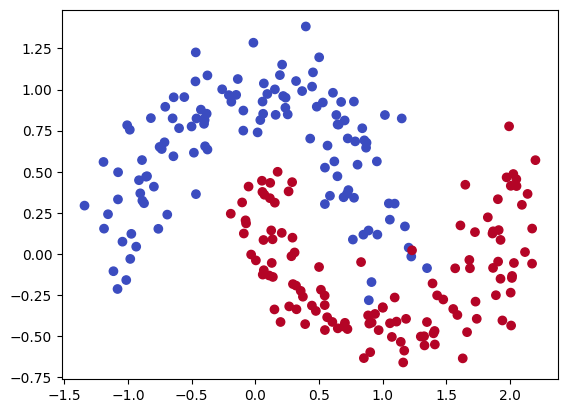

In [5]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import sklearn

# Datensatz laden
X, y = sklearn.datasets.make_moons(n_samples=240, random_state=42, noise=0.15)

# Plot der Daten
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
plt.show()

In [6]:
# Aufteilung in Test- und Trainingsdaten
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.8, random_state=42)

# Training des Modells mittels scikit-learn
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

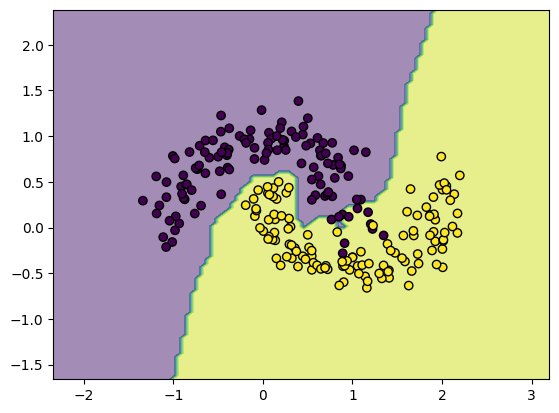

In [7]:
# Anzeige der Decision Boundary
disp = sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
    model, X, response_method='predict', alpha = 0.5)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.show()

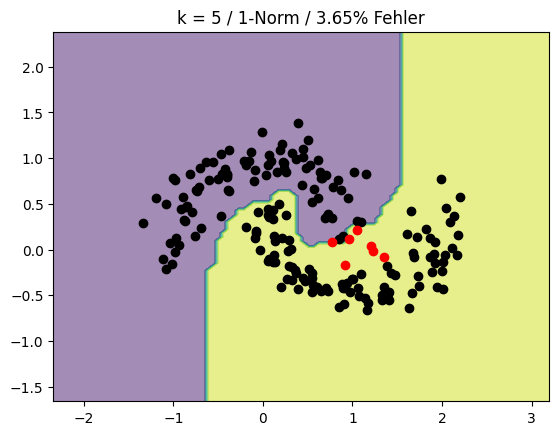

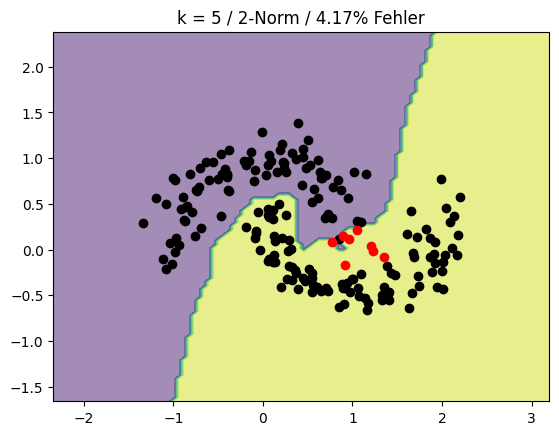

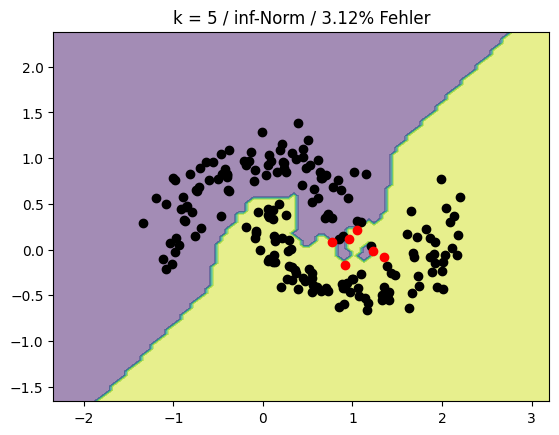

In [8]:
k = 5
for norm in [1, 2, np.inf]:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3, p=norm)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    errors = np.count_nonzero(y_pred != y_test)
    error_percentage = errors / y_test.size * 100
    
    disp = sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
        model, X, response_method='predict', alpha = 0.5)
    
    disp.ax_.scatter(X_test[y_pred == y_test, 0], X_test[y_pred == y_test, 1],
                color='black', label='correct')
    disp.ax_.scatter(X_test[y_pred != y_test, 0], X_test[y_pred != y_test, 1],
                color='red', label='wrong')
    
    plt.title(f'k = {k} / {norm}-Norm / {error_percentage:.2f}% Fehler')
    
    plt.show()

## Regression [3]

- Verwendung von stetigen Werten (statt diskreten, vgl. Klassifikation)
- Verwendung des gewichteten oder ungewichteten Mittelwerts der $k$ nächsten Nachbarn
    - auch bekannt als *Nearest Neighbour Smoothing*
- gewichteter Mittelwert: stärkere Gewichtung näher gelegener Nachbarn
    - bspw. durch inverse Abstände (`sklearn`: `weights='distance'`)
- Vorhersage entspricht Mittelwert


### Beispiel

entnommen und angepasst aus [3]

In [9]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import sklearn

# Erzeugung Test-Daten
rng = np.random.RandomState(42)
X_train = np.sort(5 * rng.rand(40, 1), axis=0)
X_test = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X_train).ravel()

# Noise hinzufügen
y[::5] += 1 * (0.5 - np.random.rand(8))

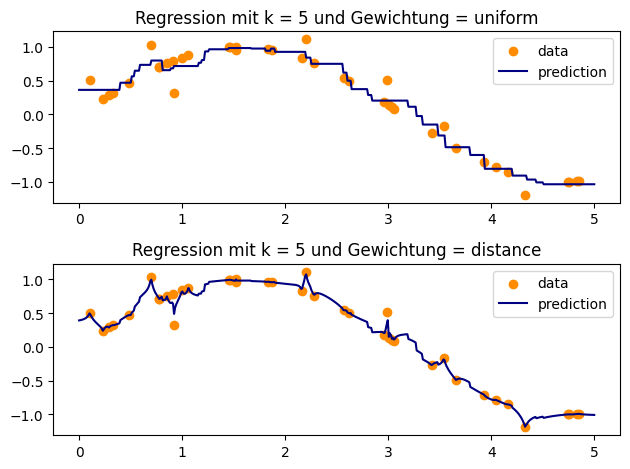

In [10]:
k = 5

# vgl. [3] (modifiziert)
for i, weights in enumerate(['uniform', 'distance']):
    knn = sklearn.neighbors.KNeighborsRegressor(k, weights=weights)
    y_ = knn.fit(X_train, y).predict(X_test)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X_train, y, color='darkorange', label='data')
    plt.plot(X_test, y_, color='navy', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title(f'Regression mit k = {k} und Gewichtung = {weights}')

plt.tight_layout()
plt.show()

## Numerische Eigenschaften [1,2]

- *Lazy-Learning*-Algorithmus $\to$ Hauptarbeit zur Zeit der Anfrage statt Training (vgl. *Eager Learning*)
    - Bildung des Modells lokal um Abfragepunkt $\to$ ggf. genauer als globale Modelle
    - Schwäche: Aufwand pro Anfrage, Berechnung wächst linear mit Größe der Trainingsdaten
    - ggf. Mischansatz mittels Verwendung anderer *Nearest Neighbour Algorithms* $\to$ schnelleres Auffinden der $k$ nächsten Nachbarn
        - bspw. $k$-dimensionaler Baum (*KD Tree*) $\to$ unbalancierter Suchbaum
        - bspw. *Ball Tree* $\to$ Verwendung von Hyper-Sphären für höherdimensionale Daten
            - v.a. für stark strukturierte, höher dimensionale Daten
- wenig Parameter
    - $k$: Suchfeld der nächsten Nachbarn für Klassifikation / Regression
    - Klassifikation: verwendete Norm (Manhatten (1), euklidisch (2), Max-/Inf-Norm)
    - Regression: Gewichtung
    - ggf. *Nearest Neighbour Algorithms*
    - vorteilhaft, vgl. stark parametrisierte Verfahren (bspw. Neuronale Netze)
- Güte stark abhängig von Dichte und Anordnung / Dimensionalität der vorliegenden Daten im Raum
    - ggf. Dimensionsreduktion als Pre-Processing


## Laufzeitverbesserung: Algorithmus zur Bestimmung der nächsten Nachbarn [1,2]
Brute-Force vs. KD-Tree vs. Ball Tree

In [11]:
%reset -f

import numpy as np
import sklearn

X, y = sklearn.datasets.make_moons(n_samples=200_000, random_state=42, noise=0.1)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.8, random_state=42)

In [12]:
import time

for algorithm in ['brute', 'kd_tree', 'ball_tree']:
    start_time = time.time()

    print(f'--- {algorithm} ---')

    model = sklearn.neighbors.KNeighborsClassifier(
        n_neighbors=3, metric='euclidean', algorithm=algorithm)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    errors = np.count_nonzero(y_preds != y_test)
    print(f'made {errors} error(s) in total,',
          f'that is {errors / y_test.size * 100:.2f}% in total')

    print(f'{time.time() - start_time} seconds\n')

--- brute ---
made 123 error(s) in total, that is 0.08% in total
3.503972053527832 seconds

--- kd_tree ---
made 123 error(s) in total, that is 0.08% in total
1.6196141242980957 seconds

--- ball_tree ---
made 123 error(s) in total, that is 0.08% in total
2.1653249263763428 seconds



$\Rightarrow$ deutliche Verbesserung durch Verwendung von KD-Tree<br>
$\Rightarrow$ Ball-Tree lohnt sich bei zwei Dimensionen (noch) nicht


## Literatur

[1] J. Frochte, „Maschinelles Lernen – Überblick und Abgrenzung“, in Maschinelles Lernen, Deutschland: Hanser, 2018, S. 110–116.

[2] scikit-learn developers, „1.6. Nearest Neighbors“, scikit-learn. Zugegriffen: 11. April 2025. [Online]. Verfügbar unter: https://scikit-learn/stable/modules/neighbors.html

[3] scikit-learn developers, „Nearest Neighbors regression“, scikit-learn. Zugegriffen: 21. April 2025. [Online]. Verfügbar unter: https://scikit-learn/stable/auto_examples/neighbors/plot_regression.html

[4] P. Bonfini, „KNN decision surface animation.gif“. Zugegriffen: 21. April 2025. [Online]. Verfügbar unter: https://commons.wikimedia.org/wiki/File:KNN_decision_surface_animation.gif

[5] M. Grüttmüller, „Klassifikation - Minimale Abstands Klassifikatoren“, in Mustererkennung, Vorlesungsskript, 2024, S. 17.